In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
memory = True
gpus = tf.config.list_physical_devices('GPU')
if gpus and memory:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-25 10:03:12.065425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:03:12.072336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:03:12.072580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:03:12.073311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="dense/dense history"+current_time,dpi=300)

In [3]:
ds, ds_info = tfds.load(
    'eurosat/all',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image/28002, label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(128)
ds = ds.cache()

In [6]:
def balanceofdataset(dataset):
    classes = [0 for i in range(10)]
    for image, label in dataset.unbatch():
        classes[label.numpy()] +=1
        #print(label.numpy())
    print(classes)

balanceofdataset(ds_train)
balanceofdataset(ds_validation)
balanceofdataset(ds_test)

[2406, 2386, 2417, 1971, 1988, 1609, 2005, 2411, 2022, 2385]
[271, 301, 290, 274, 263, 190, 244, 299, 247, 321]
[323, 313, 293, 255, 249, 201, 251, 290, 231, 294]


In [7]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [8]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  image=augment_inversion(image)


  return image,label

In [9]:
ds_train_augmented = ds_train.map(augment_data)

In [10]:
ds_validation_augmented = ds_validation.map(augment_data)

In [11]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    #elif epoch < 10:
    #    return lr * tf.math.exp(-0.1)
    elif epoch < 100:
        return lr * tf.math.exp(-0.01)
    elif epoch < 200:
        return lr * tf.math.exp(-0.001)
    else:
        return lr

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 13)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])



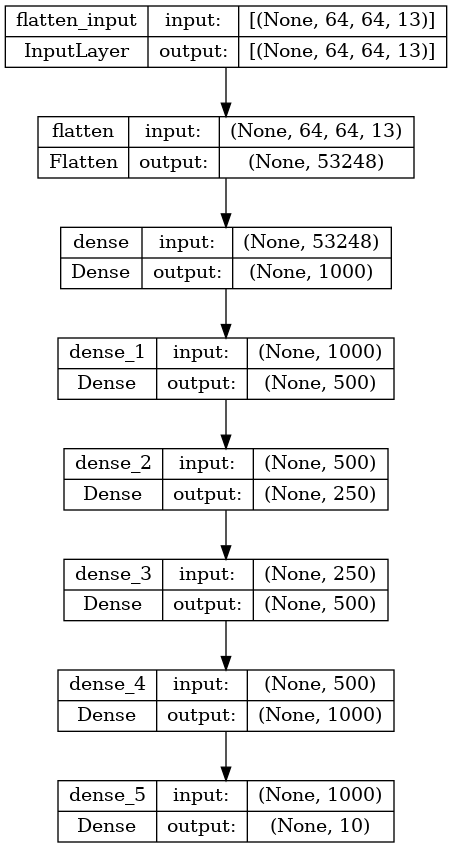

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]

)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)


In [ ]:
history = model.fit(
    ds_train_augmented,
    epochs=800,
    validation_data=ds_validation,
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        "dense/dense epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.5
    )
    ,tf.keras.callbacks.LearningRateScheduler(scheduler)]
)

Epoch 1/800
169/169 [==============================] - 10s 56ms/step - loss: 2.5969 - sparse_categorical_accuracy: 0.1925 - val_loss: 2.1887 - val_sparse_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/800
169/169 [==============================] - 10s 56ms/step - loss: 2.1197 - sparse_categorical_accuracy: 0.2557 - val_loss: 1.7564 - val_sparse_categorical_accuracy: 0.3430 - lr: 1.0000e-04
Epoch 3/800
169/169 [==============================] - 9s 53ms/step - loss: 1.7717 - sparse_categorical_accuracy: 0.3404 - val_loss: 1.3948 - val_sparse_categorical_accuracy: 0.4993 - lr: 1.0000e-04
Epoch 4/800
169/169 [==============================] - 11s 67ms/step - loss: 1.5219 - sparse_categorical_accuracy: 0.4391 - val_loss: 1.2064 - val_sparse_categorical_accuracy: 0.5548 - lr: 1.0000e-04
Epoch 5/800
169/169 [==============================] - 13s 78ms/step - loss: 1.5159 - sparse_categorical_accuracy: 0.4699 - val_loss: 1.1375 - val_sparse_categorical_accuracy: 0.5985 - lr: 1.0000e-04
E

In [ ]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="dense/dense confusion matrix"+current_time,dpi=300)
render_training_history(history)
